In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tqdm.auto import tqdm

import sys
sys.path.append("../")
import json

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-09-10 14:07:57 __main__ INFO     torch.__version__='2.4.1+cu121', torch.version.cuda='12.1'
2024-09-10 14:07:58 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-09-10 14:07:58 __main__ INFO     transformers.__version__='4.44.2'


In [3]:
from dataclasses_json import DataClassJsonMixin
from dataclasses import dataclass, field, fields
from typing import Optional
import random
from src.dataset import BridgeSample, BridgeRelation, BridgeDataset
from src.dataset import load_bridge_relation, load_bridge_relations, load_bridge_dataset        

In [4]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

model_key = "meta-llama/Meta-Llama-3-8B-Instruct"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

2024-09-10 14:08:00 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]

2024-09-10 14:08:05 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Meta-Llama-3-8B-Instruct> | size: 15316.516 MB | dtype: torch.float16 | device: cuda:0


In [5]:
states_cache_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "cache_states/mean",
    mt.name.split("/")[-1],
    "wikipedia"
)

# os.listdir(states_cache_dir)


In [6]:
import numpy as np

def load_mean_states():
    mean_states = {}
    total_tokens = 0
    for doc_cache in os.listdir(states_cache_dir):
        npz_file = np.load(os.path.join(states_cache_dir, doc_cache), allow_pickle=True)
        input_ids = npz_file["input_ids"]
        token_count = input_ids.shape[1]
        outputs = npz_file["outputs"].item()
        for key, value in outputs.items():
            if key not in mean_states:
                mean_states[key] = value * token_count
            else:
                mean_states[key] += value * token_count
        total_tokens += token_count
    
    for key in mean_states.keys():
        mean_states[key] = torch.Tensor(mean_states[key]).squeeze() / total_tokens
    
    return mean_states

# npz_file = np.load(os.path.join(states_cache_dir, "0.npz"), allow_pickle=True)
# npz_file.files

# outputs = npz_file["outputs"].item()

mean_states = load_mean_states()

In [7]:
from typing import Literal
from src.utils import experiment_utils

experiment_utils.set_seed(123456)

relation_name: Literal[
    "architect_building",
    "movie_actor",
    "sport_players",
    "superpower_characters",
    "all",
] = "sport_players"


cached_known_dir = os.path.join(
    env_utils.DEFAULT_DATA_DIR, "bridge_cached", 
    mt.name.split("/")[-1]
)
# known_data_file = os.listdir(cached_known_dir)[-1]
known_data_file = "filtered_2024-09-06T00:58:32.777195.json"

cached_known_dir = os.path.join(
    env_utils.DEFAULT_DATA_DIR, "bridge_cached", mt.name.split("/")[-1]
)
with open(os.path.join(cached_known_dir, known_data_file), "r") as f:
    json_data = json.load(f)

dataset = BridgeDataset.from_dict(json_data)
if relation_name != "all":
    relation_icq = None
    for rel in json_data["relations"]:
        if rel["name"] == relation_name:
            relation_icq = BridgeRelation.from_dict(rel)
            break
    assert (
        relation_icq is not None
    ), f"{relation_name=} is not found. Available relations: {[r['name'] for r in json_data['relations']]}"
    dataset.examples = relation_icq.examples
dataset.ensure_icl_not_in_examples()

2024-09-10 14:08:10 src.utils.experiment_utils INFO     setting all seeds to 123456
2024-09-10 14:08:10 src.dataset INFO     initialized bridge relation superpower_characters with 43 examples
2024-09-10 14:08:10 src.dataset INFO     initialized bridge relation sport_players with 58 examples
2024-09-10 14:08:10 src.dataset INFO     initialized bridge relation movie_actor with 58 examples
2024-09-10 14:08:10 src.dataset INFO     initialized bridge relation architect_building with 30 examples
2024-09-10 14:08:10 src.dataset INFO     initialized bridge relation none with 46 examples
2024-09-10 14:08:10 src.dataset INFO     initialized bridge dataset with 5 relations and 293 examples
2024-09-10 14:08:10 src.dataset INFO     initialized bridge relation sport_players with 58 examples


In [8]:
for idx, sample in enumerate(dataset.examples):
    print(idx, "=>", sample)

0 => baseball - a sport where both Babe Ruth and Hank Aaron are known for.
1 => boxing - a sport where both Floyd Mayweather and Manny Pacquiao are known for.
2 => athletics - a sport where both Usain Bolt and Carl Lewis are known for.
3 => basketball - a sport where both Michael Jordan and LeBron James are known for.
4 => soccer - a sport where both Zinedine Zidane and Ronaldinho are known for.
5 => table tennis - a sport where both Zhang Jike and Timo Boll are known for.
6 => rugby - a sport where both Richie McCaw and Brian O'Driscoll are known for.
7 => rugby - a sport where both Jonah Lomu and Dan Carter are known for.
8 => cricket - a sport where both Sachin Tendulkar and Brian Lara are known for.
9 => surfing - a sport where both Kelly Slater and Andy Irons are known for.
10 => cricket - a sport where both Shane Warne and Muttiah Muralitharan are known for.
11 => wrestling - a sport where both Hulk Hogan and The Rock are known for.
12 => soccer - a sport where both Pelé and Dieg

In [9]:
idx = 19

question, answer = dataset[idx]
print(question)
print(answer)

Given two entities, find a common link between them.
#
What is a common link between Michelle Williams and Marilyn Monroe?
A: My Week with Marilyn - a movie where Michelle Williams played the role of Marilyn Monroe.
#
What is a common link between Fallingwater and Guggenheim Museum?
A: Frank Lloyd Wright - who was the architect of both buildings Fallingwater and Guggenheim Museum.
#
What is a common link between Roger Federer and Rafael Nadal?
A: tennis - a sport where both Roger Federer and Rafael Nadal are known for.
#
What is a common link between Charles Darwin and Flamenco?
A: none - there is no connection between Charles Darwin and Flamenco.
#
What is a common link between Mr. Fantastic and Elastigirl?
A: elastic powers - an attribute that both characters Mr. Fantastic and Elastigirl possess.
#
What is a common link between Jonah Lomu and Richie McCaw?
A:
rugby - a sport where both Jonah Lomu and Richie McCaw are known for.


In [10]:
from src.tokens import prepare_input

inputs = prepare_input(prompts=question, tokenizer=mt)

In [11]:
from src.functional import predict_next_token

clean_predictions = predict_next_token(
    mt=mt,
    inputs=inputs
)[0]
clean_predictions

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


[PredictedToken(token=' rugby', prob=0.38151416182518005, logit=20.859375, token_id=47550),
 PredictedToken(token=' New', prob=0.2663397789001465, logit=20.5, token_id=1561),
 PredictedToken(token=' All', prob=0.16929587721824646, logit=20.046875, token_id=2052),
 PredictedToken(token=' Rugby', prob=0.14708681404590607, logit=19.90625, token_id=52002),
 PredictedToken(token=' they', prob=0.013054695911705494, logit=17.484375, token_id=814)]

In [12]:
from src.functional import get_hs, logit_lens, PatchSpec

ablate_mlps : list[PatchSpec] = [
    PatchSpec(
        location=(mt.mlp_module_name_format.format(i), -1),
        patch=mean_states[mt.mlp_module_name_format.format(i)]
    ) 
    for i in [0, 1]
]

last_h = get_hs(
    mt=mt,
    input=inputs,
    locations=(mt.layer_name_format.format(mt.n_layer-1), -1),
    patches=ablate_mlps
)

ablated_pred, track_ans = logit_lens(
    mt=mt,
    h=last_h,
    interested_tokens=[clean_predictions[0].token_id]
)
ablated_pred, track_ans

([PredictedToken(token=' rugby', prob=0.40934619307518005, logit=19.515625, token_id=47550),
  PredictedToken(token=' New', prob=0.22606243193149567, logit=18.921875, token_id=1561),
  PredictedToken(token=' All', prob=0.1760576069355011, logit=18.671875, token_id=2052),
  PredictedToken(token=' Rugby', prob=0.11546139419078827, logit=18.25, token_id=52002),
  PredictedToken(token=' both', prob=0.022036192938685417, logit=16.59375, token_id=2225)],
 {47550: (1,
   PredictedToken(token=' rugby', prob=0.40934619307518005, logit=19.515625, token_id=47550))})

In [13]:
list(track_ans.values())[0]

(1,
 PredictedToken(token=' rugby', prob=0.40934619307518005, logit=19.515625, token_id=47550))

In [14]:
clean_predictions[0].token_id

47550

In [15]:
from tqdm.auto import tqdm

@torch.inference_mode()
def check_ablation_effect(
    mt: ModelandTokenizer,
    question: str,
    direction: Literal["asc", "desc"] = "asc"
):
    inputs = prepare_input(prompts=question, tokenizer=mt)
    answer = predict_next_token(mt=mt, inputs=inputs, k=1)[0][0]
    ablation_spec: list[PatchSpec] = []
    effects = {}

    layers = list(range(mt.n_layer)) if direction == "asc" else list(range(mt.n_layer-1, -1, -1))
    for i in tqdm(layers):
        ablation_spec.append(
            PatchSpec(
                location=(mt.mlp_module_name_format.format(i), -1),
                patch=mean_states[mt.mlp_module_name_format.format(i)]
                # patch=torch.zeros_like(mean_states[mt.mlp_module_name_format.format(i)])
            )
        )

        ablated_last_h = get_hs(
            mt=mt, 
            input=inputs,
            locations=(mt.layer_name_format.format(mt.n_layer-1), -1),
            patches=ablation_spec
        )

        ablated_pred, track_ans =logit_lens(mt=mt, h=ablated_last_h, interested_tokens=[answer.token_id])
        rank, track_ans = list(track_ans.values())[0]
        effects[i] = track_ans
    
    return answer, effects

In [16]:
from src.utils.typing import PredictedToken

def process_ablation_effects(
    ablation_effects: list[tuple[PredictedToken], dict[int, PredictedToken]],
    metric: str = "prob"
):
    scores = {}
    for answer, effects in ablation_effects:
        for layer, effect in effects.items():
            if layer not in scores:
                scores[layer] = []
            scores[layer].append(getattr(effect, metric)/getattr(answer, metric))
    scores = {k: np.mean(v) for k, v in scores.items()}
    return scores

In [17]:
answer, effects_asc = check_ablation_effect(mt=mt, question=question)

100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


In [18]:
ablation_effects_asc = []
ablation_effects_desc = []

# limit = 5
limit = len(dataset)
for idx in range(limit):
    print(f"Processing {idx+1}/{limit}")
    question, answer = dataset[idx]
    answer, effects = check_ablation_effect(mt=mt, question=question)
    ablation_effects_asc.append((answer, effects))

    answer, effects = check_ablation_effect(mt=mt, question=question, direction="desc")
    ablation_effects_desc.append((answer, effects))

Processing 1/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 2/58


100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Processing 3/58


100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


Processing 4/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 5/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 6/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 7/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 8/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 9/58


100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


Processing 10/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 11/58


100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


Processing 12/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 13/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 14/58


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


Processing 15/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 16/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 17/58


100%|██████████| 32/32 [00:18<00:00,  1.73it/s]


Processing 18/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 19/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 20/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 21/58


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


Processing 22/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 23/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 24/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 25/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 26/58


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


Processing 27/58


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


Processing 28/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 29/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 30/58


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


Processing 31/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 32/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 33/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 34/58


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


Processing 35/58


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


Processing 36/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 37/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 38/58


100%|██████████| 32/32 [00:20<00:00,  1.57it/s]


Processing 39/58


100%|██████████| 32/32 [00:20<00:00,  1.60it/s]


Processing 40/58


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


Processing 41/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 42/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 43/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 44/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 45/58


100%|██████████| 32/32 [00:20<00:00,  1.60it/s]


Processing 46/58


100%|██████████| 32/32 [00:20<00:00,  1.60it/s]


Processing 47/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 48/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 49/58


100%|██████████| 32/32 [00:19<00:00,  1.60it/s]


Processing 50/58


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


Processing 51/58


100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


Processing 52/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 53/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 54/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 55/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 56/58


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


Processing 57/58


100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


Processing 58/58


100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


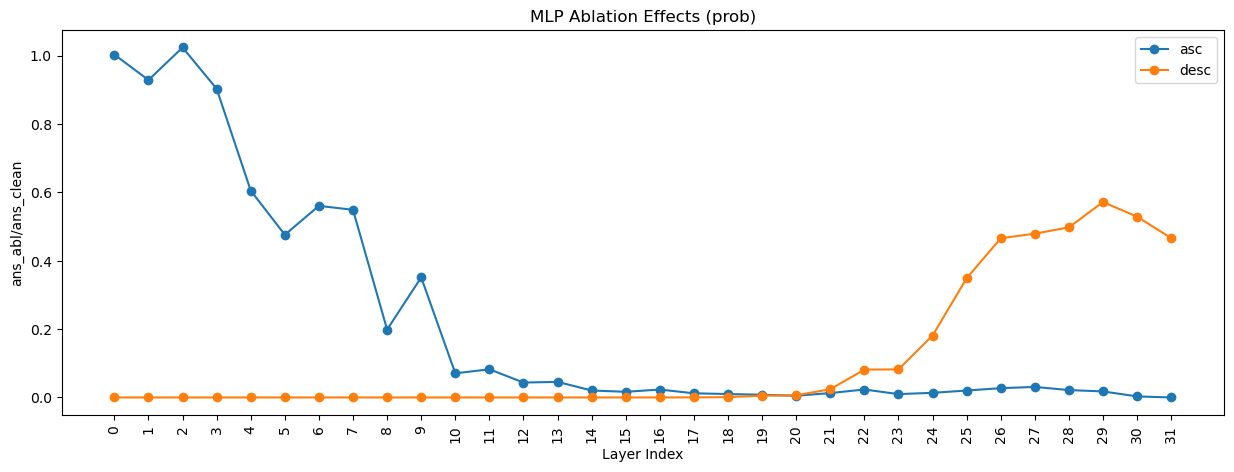

In [26]:
metric = "prob"

scores_asc = process_ablation_effects(ablation_effects_asc, metric)
scores_desc = process_ablation_effects(ablation_effects_desc, metric)

import matplotlib.pyplot as plt

keys = list(range(mt.n_layer))

plt.figure(figsize=(15, 5))
plt.title(f"MLP Ablation Effects ({metric})")
plt.plot([scores_asc[k] for k in keys], marker="o", label="asc")
plt.plot([scores_desc[k] for k in keys], marker="o", label="desc")
plt.xticks(keys, rotation=90)
plt.xlabel("Layer Index")
plt.ylabel("ans_abl/ans_clean")
plt.legend()

plt.show()

### Path Blocking

In [15]:
from src.utils.typing import TokenizerOutput, PredictedToken
from src.tokens import align_bridge_entities_in_query

def do_path_ablation(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    restore_states: list[PatchSpec],
    block_locations: list[tuple[str, int]],
    ans_token: int
) -> PredictedToken:
    corrupted_states = get_hs(
        mt=mt, input=input, locations=block_locations, return_dict=True
    )
    # restore the clean states from `restore_states`
    # patch the corrupted states back to block those locations
    patch_spec = restore_states + [
        PatchSpec(
            location=loc,
            patch=corrupted_states[loc]
        )
        for loc in block_locations
    ]
    last_h = get_hs(
        mt=mt, 
        input=input,
        locations=(mt.layer_name_format.format(mt.n_layer-1), -1),
        patches=patch_spec,
        return_dict=False
    )

    ablated_pred, track_ans=logit_lens(mt=mt, h=last_h, interested_tokens=[ans_token])
    rank, track_ans = list(track_ans.values())[0]

    return track_ans

def trace_path_ablation_effects(
    mt: ModelandTokenizer,
    clean_ques: str,
    clean_entity_pair: tuple[str, str],
    patch_ques: str,
    patch_entity_pair: tuple[str, str],
):
    inps = align_bridge_entities_in_query(
        mt=mt,
        clean_ques=clean_ques,
        clean_entity_pair=clean_entity_pair,
        patch_ques=patch_ques,
        patch_entity_pair=patch_entity_pair,
    )
    clean_inputs = inps["clean_inputs"]
    patch_inputs = inps["patch_inputs"]
    # query_start = inps["query_start"]
    # subj_1_range = inps["subj_1_range"]
    # subj_2_range = inps["subj_2_range"]

    patch_ans = predict_next_token(mt=mt, inputs=patch_inputs, k=1)[0][0]
    logger.debug(f"{patch_ans=}")

    clean_ans, corrupt_rank = predict_next_token(
        mt=mt, inputs=clean_inputs,
        token_of_interest=[(mt.tokenizer.decode(patch_ans.token_id))],
    )
    clean_ans = clean_ans[0][0]
    corrupt_rank, base_ans = corrupt_rank[0]
    logger.debug(f"{clean_ans=}")
    logger.debug(f"{corrupt_rank=} | {base_ans=}")

    assert clean_inputs["input_ids"].shape[1] == patch_inputs["input_ids"].shape[1]

    TOKEN_IDX = -1
    mlp_ablation_locations = [
        (mt.mlp_module_name_format.format(i), TOKEN_IDX)
        for i in range(mt.n_layer)
    ]
    attn_ablation_locations = [
        (mt.attn_module_name_format.format(i), TOKEN_IDX)
        for i in range(mt.n_layer)
    ]
    residual_locations = [
        (mt.layer_name_format.format(i), TOKEN_IDX)
        for i in range(mt.n_layer)
    ]

    path_blocking_effects = {}

    restore_states = get_hs(
        mt=mt, input=patch_inputs, locations=residual_locations, return_dict=True
    )
    logger.debug("="*50)
    for i in range(mt.n_layer):
        restore_location = (mt.layer_name_format.format(i), TOKEN_IDX)
        logger.debug(restore_location)
        cur_restore = [
            PatchSpec(
                location=restore_location,
                patch=restore_states[restore_location]
            )
        ]
        h_restore_pred = do_path_ablation(
            mt=mt, input=clean_inputs,
            restore_states=cur_restore,
            block_locations=[],         # don't block anything
            ans_token=patch_ans.token_id
        )
        logger.debug(f"{h_restore_pred=}")

        mlp_ablation_pred = do_path_ablation(
            mt=mt, input=clean_inputs,
            restore_states=cur_restore,
            block_locations=mlp_ablation_locations, # block the MLP contributions   
            ans_token=patch_ans.token_id
        )
        logger.debug(f"{mlp_ablation_pred=}")

        attn_ablation_pred = do_path_ablation(
            mt=mt, input=clean_inputs,
            restore_states=cur_restore,
            block_locations=attn_ablation_locations,   # block the attention contributions
            ans_token=patch_ans.token_id
        )
        logger.debug(f"{attn_ablation_pred=}")

        path_blocking_effects[i] = {
            "h_restored": h_restore_pred,
            "mlp_blocked": mlp_ablation_pred,
            "attn_blocked": attn_ablation_pred
        }
        logger.debug("-"*50)
    
    return dict(
        clean_inputs=clean_inputs,
        patch_inputs=patch_inputs,
        patch_ans=patch_ans,
        base_ans=base_ans,
        patch_blocking_effects=path_blocking_effects
    )

In [16]:
clean_idx = 28
patch_idx = 43

clean_icq = dataset[clean_idx]
patch_icq = dataset[patch_idx]

print(f"{dataset.icl_examples=}")
print(f"{dataset.examples[clean_idx]=}")
print(f"{dataset.examples[patch_idx]=}")

dataset.icl_examples=[BridgeSample(bridge='My Week with Marilyn', entity_pair=['Michelle Williams', 'Marilyn Monroe'], description='My Week with Marilyn - a movie where Michelle Williams played the role of Marilyn Monroe.', relation='movie_actor'), BridgeSample(bridge='Frank Lloyd Wright', entity_pair=['Fallingwater', 'Guggenheim Museum'], description='Frank Lloyd Wright - who was the architect of both buildings Fallingwater and Guggenheim Museum.', relation='architect_building'), BridgeSample(bridge='tennis', entity_pair=['Roger Federer', 'Rafael Nadal'], description='tennis - a sport where both Roger Federer and Rafael Nadal are known for.', relation='sport_players'), BridgeSample(bridge='none', entity_pair=['Charles Darwin', 'Flamenco'], description='none - there is no connection between Charles Darwin and Flamenco.', relation='none'), BridgeSample(bridge='elastic powers', entity_pair=['Mr. Fantastic', 'Elastigirl'], description='elastic powers - an attribute that both characters Mr

In [17]:
path_blocking_effects = trace_path_ablation_effects(
    mt=mt,
    clean_ques=dataset[clean_idx][0],
    clean_entity_pair=dataset.examples[clean_idx].entity_pair,
    patch_ques=dataset[patch_idx][0],
    patch_entity_pair=dataset.examples[patch_idx].entity_pair,
)

In [35]:
from scripts.causal_tracing import sample_icq_with_different_bridge

limit = len(dataset)
path_blocking_effects = []

experiment_utils.set_seed(123456)

for patch_idx in range(limit):
    logger.info(f"Processing {patch_idx+1}/{limit}")
    patch_qa = dataset[patch_idx]
    clean_idx = sample_icq_with_different_bridge(
        dataset.examples, dataset.examples[patch_idx]
    )
    clean_qa = dataset[clean_idx]

    path_blocking_effects.append(
        trace_path_ablation_effects(
            mt=mt,
            clean_ques=clean_qa[0],
            clean_entity_pair=dataset.examples[clean_idx].entity_pair,
            patch_ques=patch_qa[0],
            patch_entity_pair=dataset.examples[patch_idx].entity_pair,
        )
    )

2024-09-10 14:01:25 src.utils.experiment_utils INFO     setting all seeds to 123456
2024-09-10 14:01:25 __main__ INFO     Processing 1/3
2024-09-10 14:01:25 src.tokens DEBUG    clean_subj_ranges=[(185, 187), (188, 190)]
2024-09-10 14:01:25 src.tokens DEBUG    t=185 |  Kobe
2024-09-10 14:01:25 src.tokens DEBUG    t=186 |  Bryant
2024-09-10 14:01:25 src.tokens DEBUG    --------------------------------------------------
2024-09-10 14:01:25 src.tokens DEBUG    t=188 |  Magic
2024-09-10 14:01:25 src.tokens DEBUG    t=189 |  Johnson
2024-09-10 14:01:25 src.tokens DEBUG    ==================================================
2024-09-10 14:01:25 src.tokens DEBUG    patch_subj_ranges=[(185, 187), (188, 190)]
2024-09-10 14:01:25 src.tokens DEBUG    t=185 |  Babe
2024-09-10 14:01:25 src.tokens DEBUG    t=186 |  Ruth
2024-09-10 14:01:25 src.tokens DEBUG    --------------------------------------------------
2024-09-10 14:01:25 src.tokens DEBUG    t=188 |  Hank
2024-09-10 14:01:25 src.tokens DEBUG    

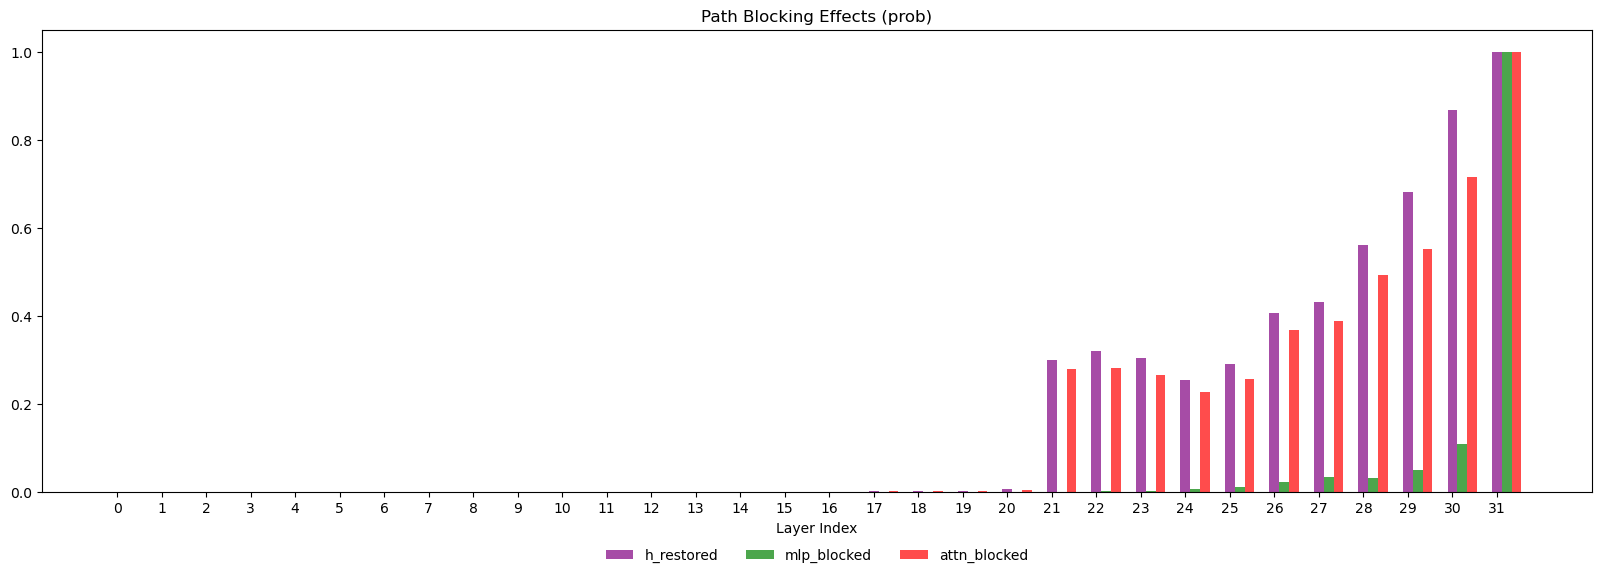

In [38]:
def process_path_blocking_results(
    path_blocking_effects: list[dict],
    metric: str = "prob"
):
    h_restored = {l: [] for l in range(mt.n_layer)}
    mlp_blocked = {l: [] for l in range(mt.n_layer)}
    attn_blocked = {l: [] for l in range(mt.n_layer)}
    for effect in path_blocking_effects:
        high_bar = getattr(effect["patch_ans"], metric) 
        low_bar = getattr(effect["base_ans"], metric)
        denominator = high_bar - low_bar
        for l in range(mt.n_layer):
            h_restored[l] = (getattr(effect["patch_blocking_effects"][l]["h_restored"], metric) - low_bar) / denominator
            mlp_blocked[l] = (getattr(effect["patch_blocking_effects"][l]["mlp_blocked"], metric) - low_bar) / denominator
            attn_blocked[l] = (getattr(effect["patch_blocking_effects"][l]["attn_blocked"], metric) - low_bar) / denominator
    
    return {
        l : {
            "h_restored": np.mean(h_restored[l]),
            "mlp_blocked": np.mean(mlp_blocked[l]),
            "attn_blocked": np.mean(attn_blocked[l])
        } for l in range(mt.n_layer)
    }

metric="prob"
plot_results = process_path_blocking_results(path_blocking_effects, metric)

from matplotlib import pyplot as plt

plt.figure(figsize=(20, 6))
bar_width = 0.22

plt.title(f"Path Blocking Effects ({metric})")
keys = list(range(mt.n_layer))
color_map = {
    "h_restored": "purple",
    "mlp_blocked": "green",
    "attn_blocked": "red"
}

for idx, kind in enumerate(["h_restored", "mlp_blocked", "attn_blocked"]):
    plt.bar(
        [k + idx*bar_width for k in keys],
        height=[plot_results[k][kind] for k in keys],
        width=bar_width,
        label=kind,
        alpha=0.7,
        color=color_map[kind]
    )

plt.legend(ncol = 4, bbox_to_anchor=(0.5, -.18), loc='lower center', frameon=False)
plt.xticks(keys)
plt.xlabel("Layer Index")
plt.show()
